In [1]:
cd drive/MyDrive/profile_labs/image_segmentation/

/content/drive/MyDrive/profile_labs/image_segmentation


In [2]:
import numpy as np
import math
import scipy.sparse as sparse
from scipy.sparse import linalg as sparse_la
from scipy import linalg as lin
from imageio import imread
from matplotlib import pyplot as plt

In [3]:
# lablacian helps keep track of similarity across pixles

def laplacian(A):
    """Compute the Laplacian matrix of the graph G that has adjacency matrix A.

    Parameters:
        A ((N,N) ndarray): The adjacency matrix of an undirected graph G.

    Returns:
        L ((N,N) ndarray): The Laplacian matrix of G.
    """
    A = np.array(A)
    rowSums = [sum(row) for row in A]
    print(rowSums)
    A = A * -1
    for i, element in enumerate(rowSums):
        A[i][i] = element
    return A

In [4]:
# helper functions for image segmenter

def connectivity(A, tol=1e-8):
    """Compute the number of connected components in the graph G and its
    algebraic connectivity, given the adjacency matrix A of G.

    Parameters:
        A ((N,N) ndarray): The adjacency matrix of an undirected graph G.
        tol (float): Eigenvalues that are less than this tolerance are
            considered zero.

    Returns:
        (int): The number of connected components in G.
        (float): the algebraic connectivity of G.
    """
    lap = np.array(laplacian(A))
    eigValues = np.real(lin.eigvals(lap))
    connected = 0

    for i in range(len(eigValues)):
        if eigValues[i] <= tol:
            eigValues[i] = 0
            connected += 1
    algebraic_connectivity = np.sort(eigValues)
    algebraic_connectivity = algebraic_connectivity[1]
    return connected, algebraic_connectivity


def get_neighbors(index, radius, height, width):
    """Calculate the flattened indices of the pixels that are within the given
    distance of a central pixel, and their distances from the central pixel.

    Parameters:
        index (int): The index of a central pixel in a flattened image array
            with original shape (radius, height).
        radius (float): Radius of the neighborhood around the central pixel.
        height (int): The height of the original image in pixels.
        width (int): The width of the original image in pixels.

    Returns:
        (1-D ndarray): the indices of the pixels that are within the specified
            radius of the central pixel, with respect to the flattened image.
        (1-D ndarray): the euclidean distances from the neighborhood pixels to
            the central pixel.
    """
    # Calculate the original 2-D coordinates of the central pixel.
    row, col = index // width, index % width

    # Get a grid of possible candidates that are close to the central pixel.
    r = int(radius)
    x = np.arange(max(col - r, 0), min(col + r + 1, width))
    y = np.arange(max(row - r, 0), min(row + r + 1, height))
    X, Y = np.meshgrid(x, y)

    # Determine which candidates are within the given radius of the pixel.
    R = np.sqrt(((X - col)**2 + (Y - row)**2))
    mask = R < radius
    return (X[mask] + Y[mask]*width).astype(np.int), R[mask]

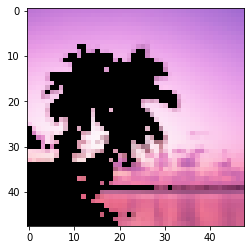

In [8]:
class ImageSegmenter:
    """Class for storing and segmenting images."""

    def __init__(self, filename):
        """Read the image file. Store its brightness values as a flat array."""

        # loading image, nomralizing, and reshaping
        self.image = imread(filename)

        self.scaled = self.image / 255

        self.gray = True

        if len(self.scaled.shape) == 3:
            self.gray = False

        self.brightness = self.scaled
        if not self.gray:
            self.brightness = self.scaled.mean(axis=2)

        self.M, self.N = self.brightness.shape
        self.flat_brightness = np.ravel(self.brightness)

    def show_original(self):
        """Display the original image."""
        if self.gray:
            plt.imshow(self.image, cmap="gray")

        else:
            plt.imshow(self.image)
        plt.axis("off")
        plt.show()

    def adjacency(self, r=5., sigma_B2=.02, sigma_X2=3.):
        """Compute the Adjacency and Degree matrices for the image graph."""

        m, n = self.scaled.shape[0], self.scaled.shape[1]
        A = sparse.lil_matrix((m*n, m*n))

        D = np.zeros(m*n)

        for i in range(m*n):
            indices, distances = get_neighbors(i, r, m, n)
            weights = np.exp((-np.abs(self.flat_brightness[i]- self.flat_brightness[indices]) / sigma_B2) - distances / sigma_X2)
            A[i,indices] = weights
            D[i] = sum(weights)
        return sparse.csc_matrix(A), D

    def cut(self, A, D):
        # perform graph cut by calculating eigenvalues of adjacency and masking
        # out values associated with low eigenvalues
        L = sparse.csgraph.laplacian(A)
        D_sqrt = sparse.diags(D**-0.5).tocsc()
        DLD = D_sqrt@L@D_sqrt
        eig_vec = sparse_la.eigsh(DLD, which="SM",k=2)[1][:,1]
        m,n = self.scaled.shape[0], self.scaled.shape[1]
        eig_vec = eig_vec.reshape((m,n))
        mask = eig_vec > 0
        return mask

    def segment(self, r=5., sigma_B=.02, sigma_X=3.):
        # calculate adjacency and get first cut
        A,D = self.adjacency(r=r, sigma_B2 = sigma_B, sigma_X2=sigma_X)
        mask = self.cut(A,D)

        # f, axarr = plt.subplots(1,3, figsize=(12,25))

        # if we are working with a colored image then we need to 
        # broadcast the mask to the different channels
        if not self.gray:

            positive = self.scaled.copy()
            negative = self.scaled.copy()

            for i, row in enumerate(mask):
                for j, cell in enumerate(row):
                    if cell:
                        negative[i][j] = negative[i][j] * 0
                    else:
                        positive[i][j] = positive[i][j] * 0

            plt.imshow(negative)

            # axarr[0].imshow(self.scaled) # show original
            # axarr[1].imshow(positive) # show first cut
            # axarr[2].imshow(negative) # show second cut
        else:
            axarr[0].imshow(self.scaled, cmap="gray")
            axarr[1].imshow(mask * self.scaled, cmap="gray")
            axarr[2].imshow(~mask * self.scaled, cmap="gray")
        plt.show()

palm_trees = ImageSegmenter("dream.png")

# palm_trees.show_original()

palm_trees.segment()

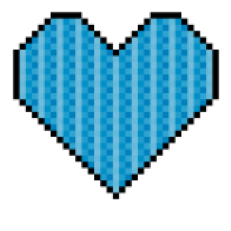

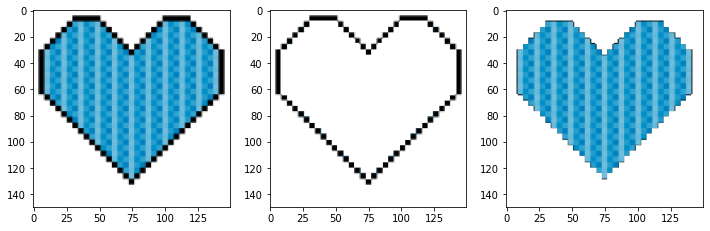

In [ ]:
palm_trees = ImageSegmenter("blue_heart.png")
palm_trees.show_original()
palm_trees.segment()
